Created by: <a href=https://github.com/morkapronczay>morkapronczay</a>

# THE CONDORCET JURY THEOREM

### A DEMONSTRATIVE NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#### We are going to demonstrate the theory - and implicitly the Law of Large Numbers (LLN) - through the following example:
* imagine a jury with n_juries (1, 2...20) person
* who are right in probs_right (0.25, 0.26...0.75) portion of times (with this probability)
* let's examine 5 realizations to ensure some robustness

In [2]:
# simulations per setup - to ensure robust results
num_real = 5
# probability that an individual is right
probs_right = [round(0.25 + 0.01 * n, 2) for n in range(51)]
# how many individual is voting
n_juries = range(1, 21)

In [3]:
# cartesian product -> parameter grid
param_set = list(product(probs_right, n_juries))

### HELPER FUNCTIONS

In [4]:
def get_pos_outcome_prob(prob_right, n_jury):
    ''' 
    Returns the proportion of individuals
    ending up with the right decision in
    a single realization.
    '''
    return np.mean(np.random.binomial(n=1, p=prob_right, size=n_jury))

def n_trials_outcome(n, prob_right, n_jury, thresh=0.5):
    ''' 
    Returns the proportion of 
    juries ending up with the right 
    decision in n independent realizations
    with a majority vote.
    '''
    return np.mean(np.array([get_pos_outcome_prob(prob_right=prob_right, n_jury=n_jury) > thresh for n in range(n)])) 

In [5]:
# store outcomes per realization
outcomes = {}
# store outcomes as a table
dfs = {}
# store pivoted, to create a heatmap
to_heatmap = {}


for i in range(num_real):
    # here we use 1 realizations, and examine different realizations separately
    # for didactic reasons. A more robust approach would set n to a higher number!
    outcomes[i] = {param: n_trials_outcome(n=1, prob_right=param[0], n_jury=param[1]) for param in param_set}
    # n_trials_outcome(n=1, *param) would work as well!
    
    # create dataframe and do some carpenting to make it nicer
    df = pd.DataFrame.from_dict(outcomes[i], orient='index').reset_index()
    df.columns = ['index', 'pos_outcome_prob']
    df['prob_right'] = df['index'].str[0]
    df['n_jury'] = df['index'].str[1]
    df.drop('index', axis=1, inplace=True)
    
    # store data
    dfs[i] = df.copy()
    to_heatmap[i] = df.pivot(index='n_jury', columns='prob_right', values='pos_outcome_prob')

In [6]:
dfs[0].head()

,pos_outcome_prob,prob_right,n_jury
0,0.0,0.25,1
1,0.0,0.25,2
2,0.0,0.25,3
3,0.0,0.25,4
4,0.0,0.25,5


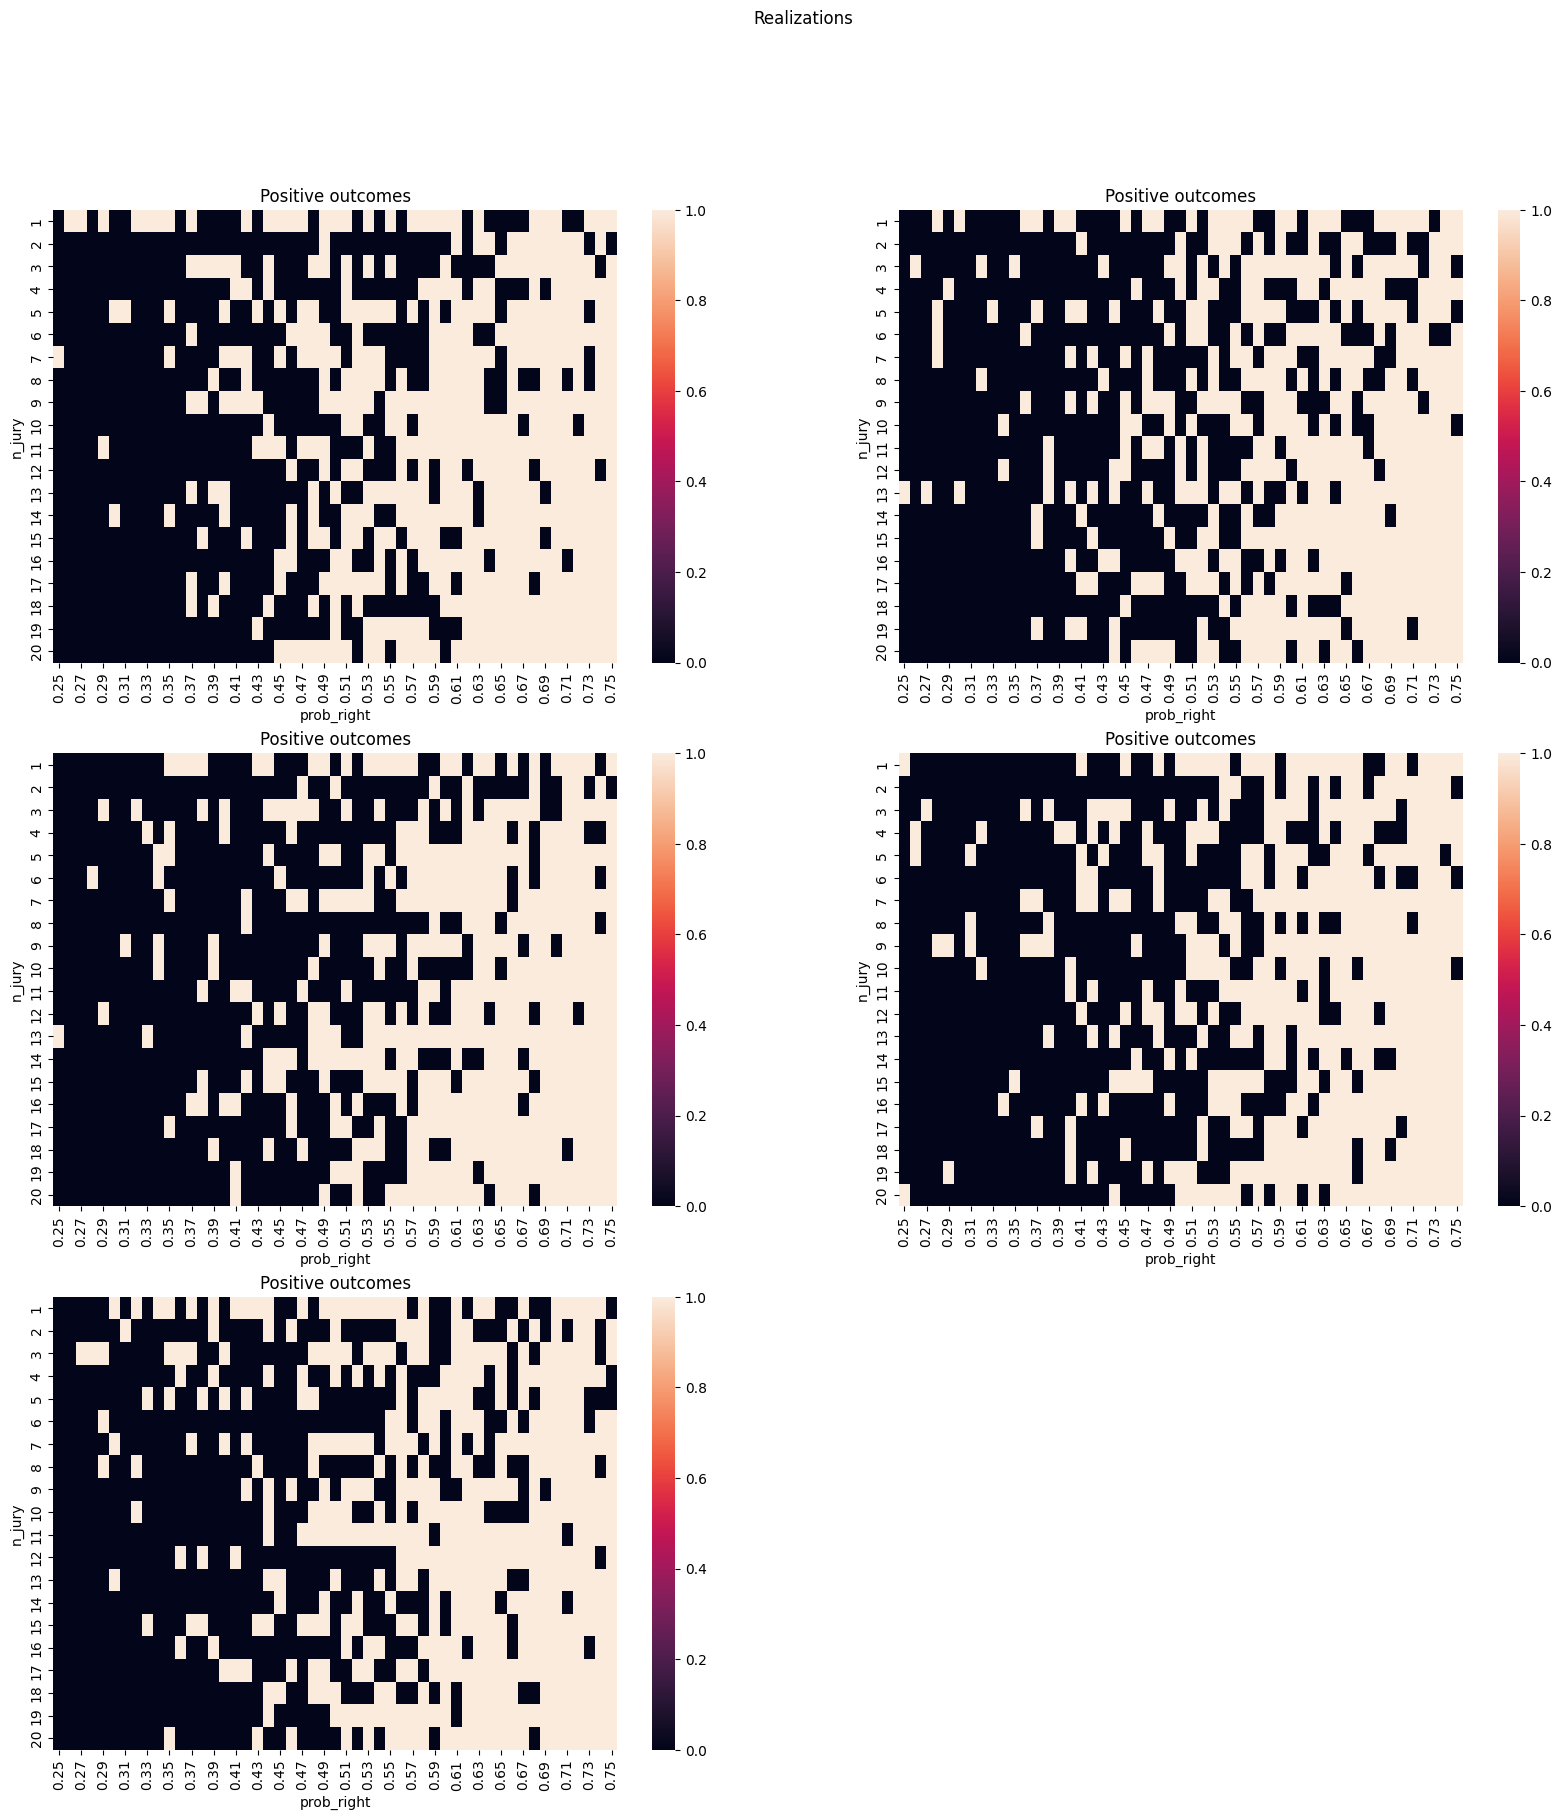

In [7]:
# visualize positive outcomes in the 5 different 
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle(f'Realizations')
ax_flat = ax.flatten()
for i, a in enumerate(ax_flat):
    # remove last, not needed axis
    if i == 5:
        a.remove()
        break
    
    # create heatmap of outcomes
    sns.heatmap(to_heatmap[i], ax=a)
    a.set_title('Positive outcomes')
plt.show()

## EXAMINE PROBABILITIES BELOW/UNDER 0.5 SEPARATELY

In [8]:
low_probs = {i: to_heatmap[i].loc[:, [f for f in to_heatmap[i].columns if f < 0.5]] for i in to_heatmap.keys()}
high_probs = {i: to_heatmap[i].loc[:, [f for f in to_heatmap[i].columns if f > 0.5]] for i in to_heatmap.keys()}

Realization 1:


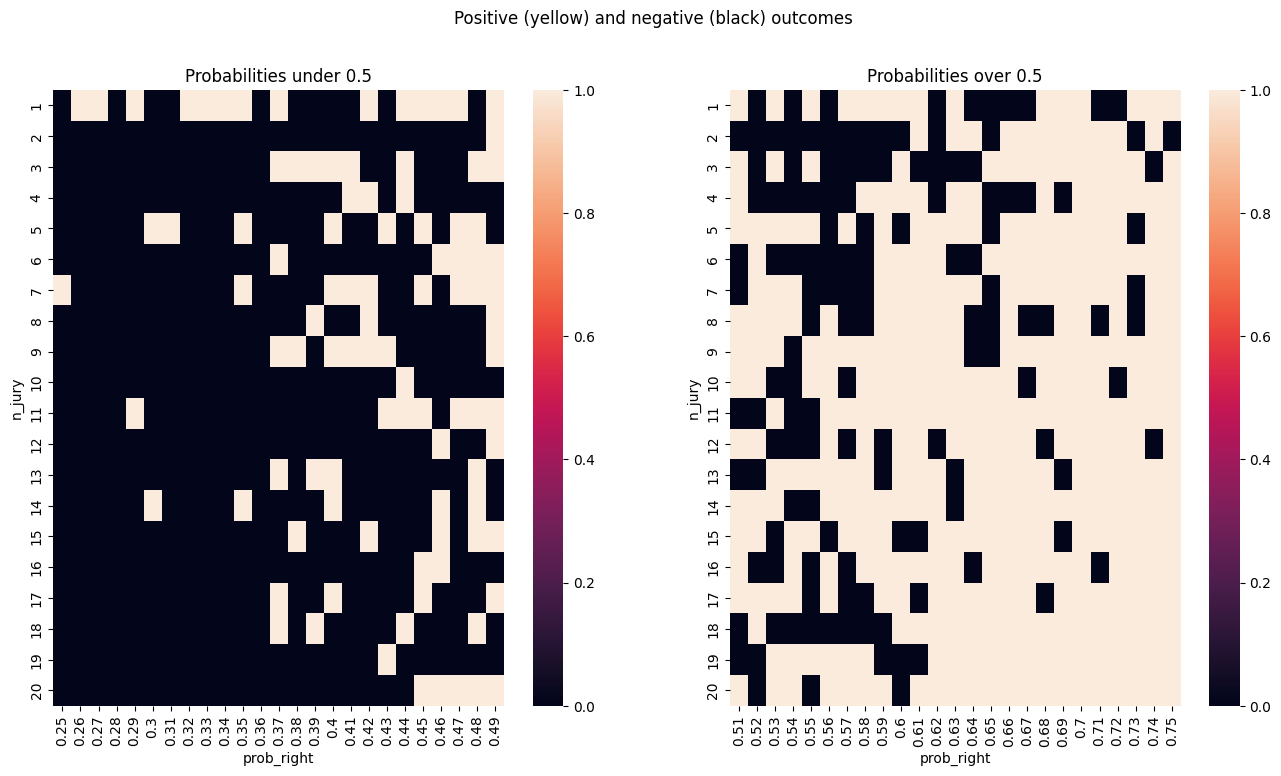

Realization 2:


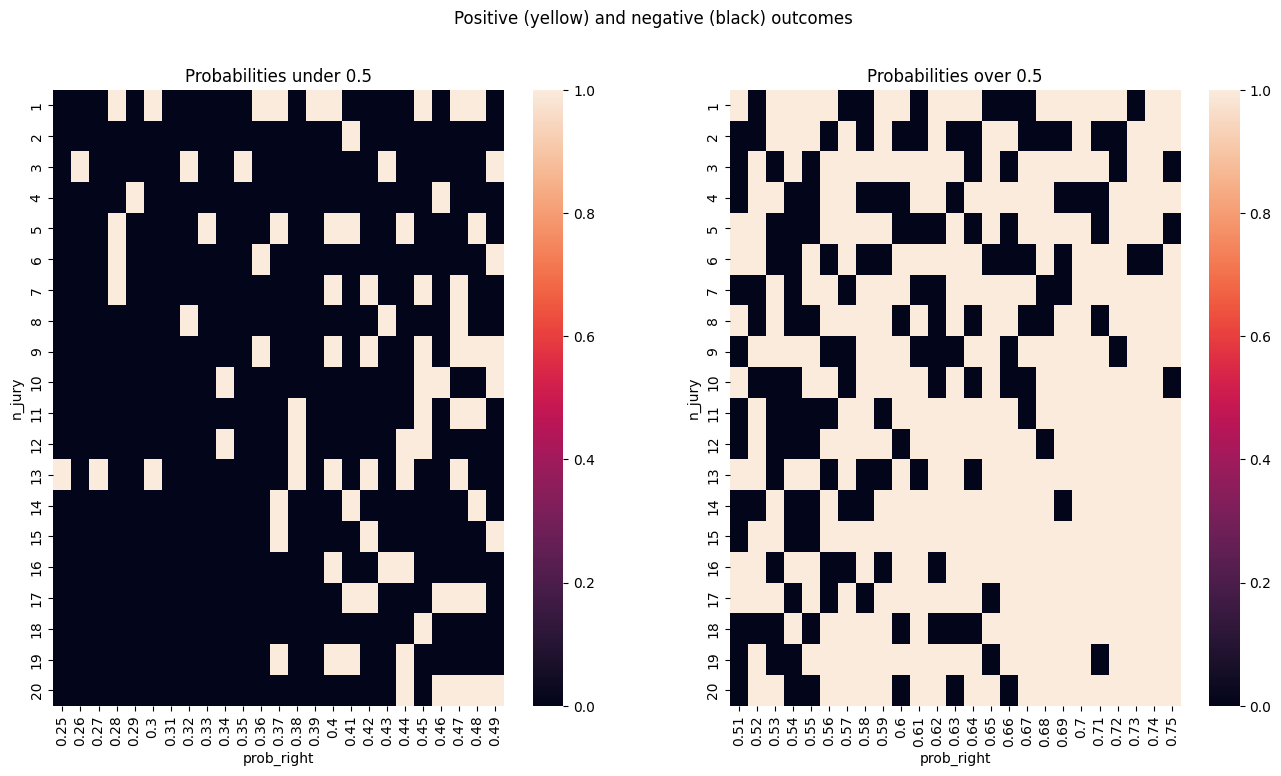

Realization 3:


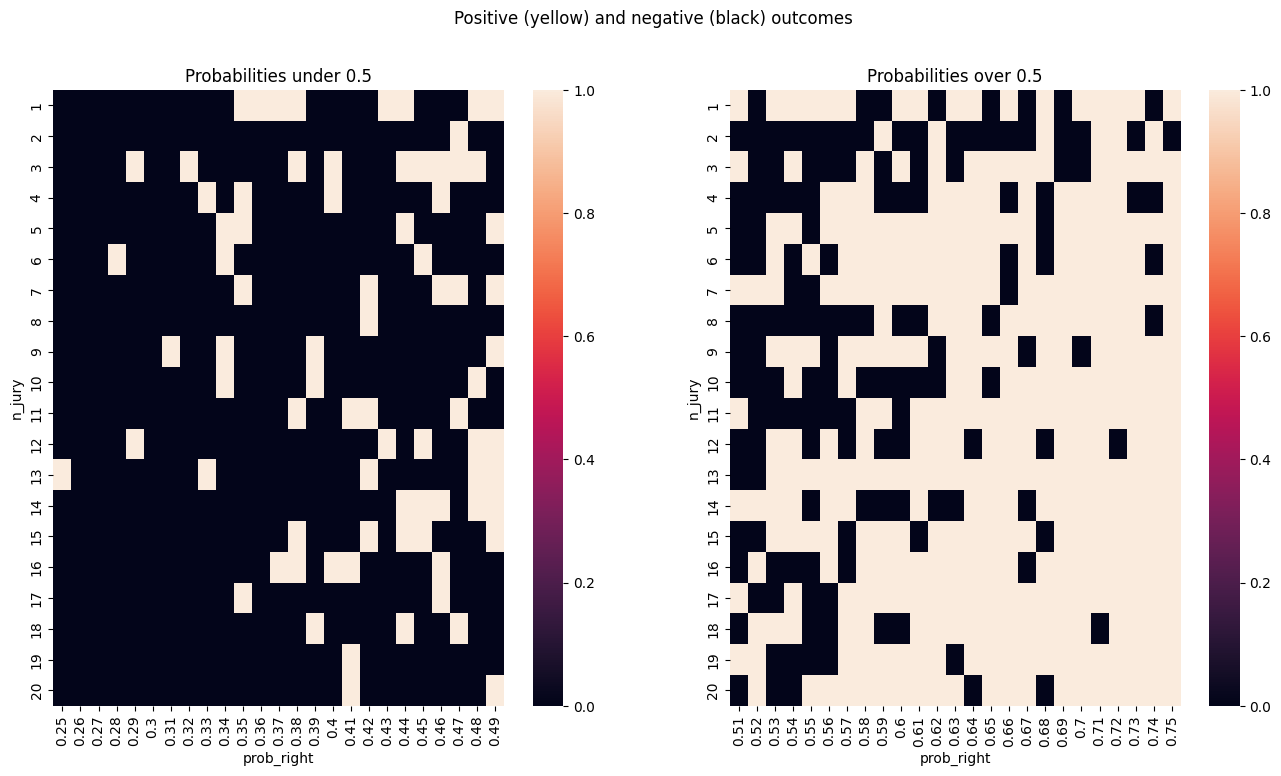

Realization 4:


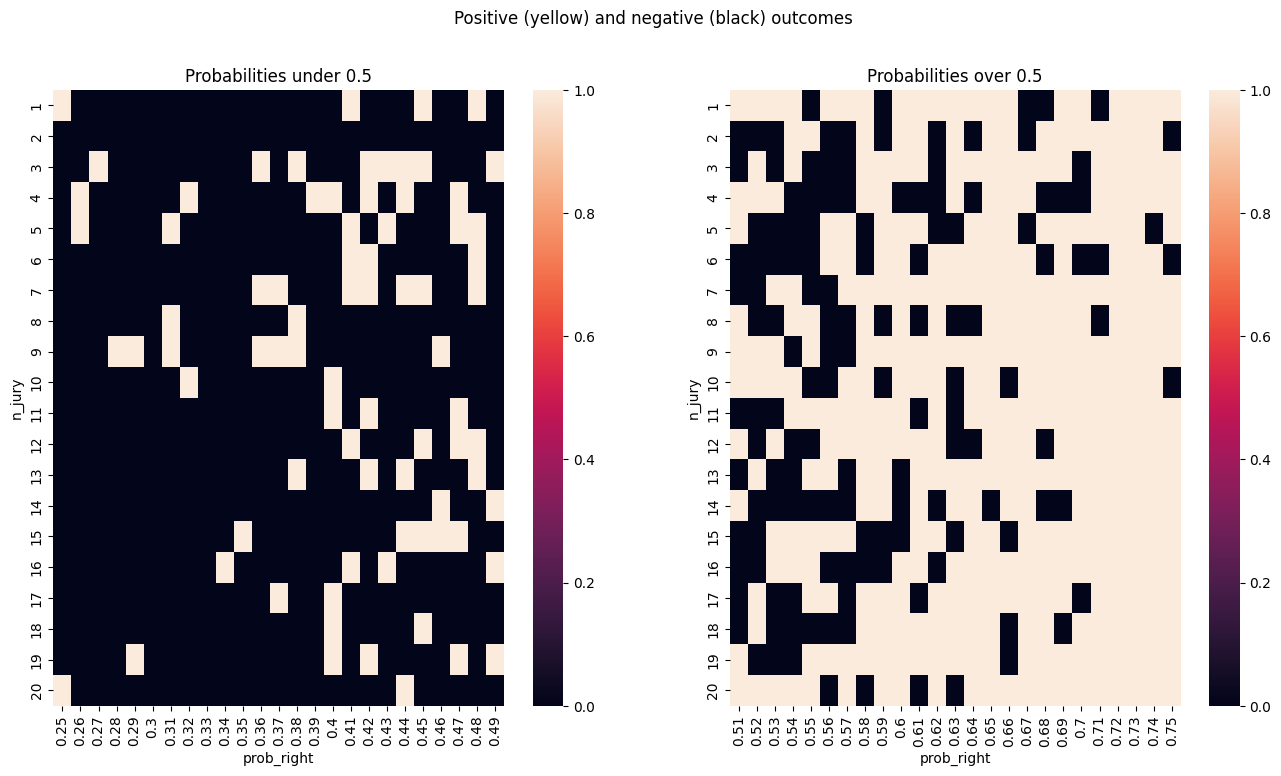

Realization 5:


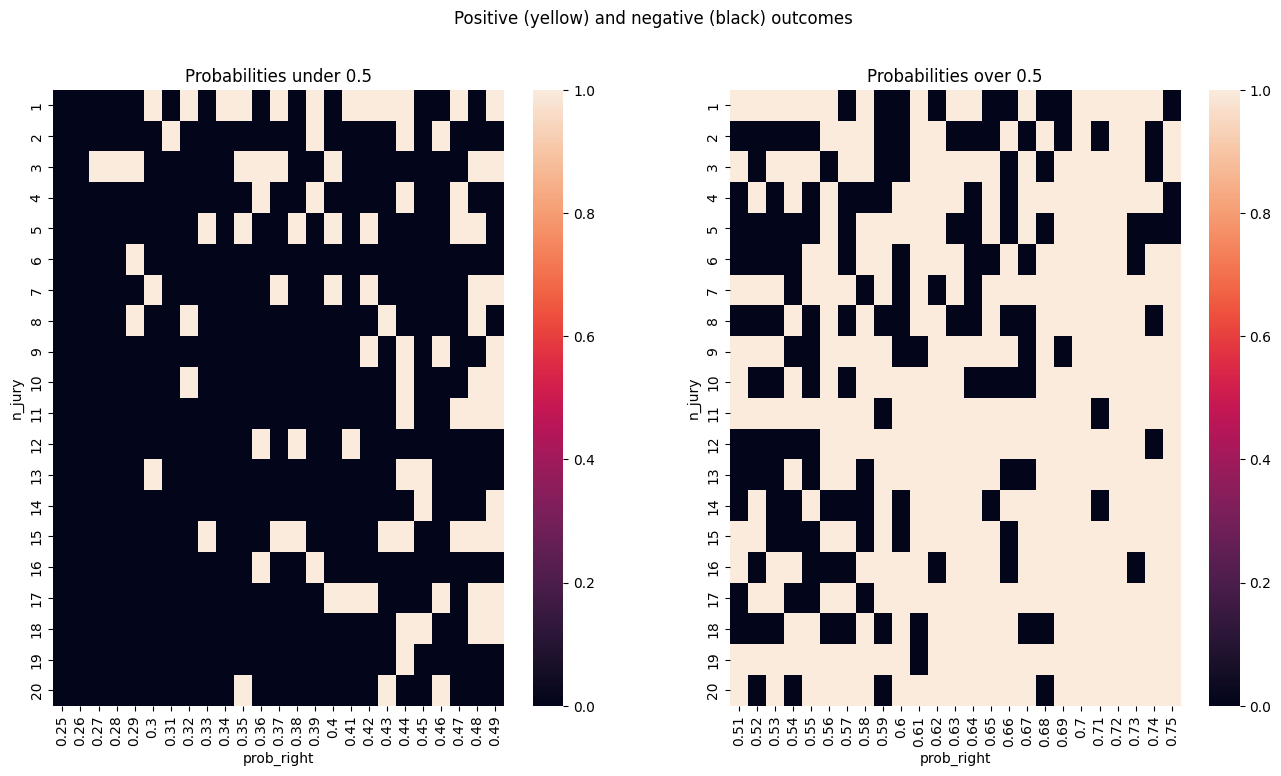

In [9]:
for i in to_heatmap.keys():
    print(f'Realization {i+1}:')
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    sns.heatmap(low_probs[i], ax=ax[0])
    sns.heatmap(high_probs[i], ax=ax[1])
    fig.suptitle('Positive (yellow) and negative (black) outcomes')
    ax[0].set_title('Probabilities under 0.5')
    ax[1].set_title('Probabilities over 0.5')
    plt.show()

#### We can see that at probabilities under 0.5, the upper right is more yellow, while at probabilities over 0.5, the lower right is.

That is because of the law of large numbers:
* with low probabilities, a single jury has a chance (p) to be right - while the majority vote of 20 has significantly **lower**, and conversely
*  with high probabilities, a single jury has a chance (p) to be right - while the majority vote of 20 has significantly **higher**

#### For me, the connection is visually evident, but some may argue it is not. 
Let's use a simple logistic regression to prove, what we found.

In [10]:
# create data of all realizations
data = pd.concat(dfs.values())

# separete them around 0.5
data_low = data[data['prob_right'] < 0.5].copy()
data_high = data[data['prob_right'] > 0.5].copy()

# create LogisticRegression objects and fit them
logit_low = LogisticRegression(solver='lbfgs').fit(
    data_low.drop('pos_outcome_prob', axis=1), data_low['pos_outcome_prob'])
logit_high = LogisticRegression(solver='lbfgs').fit(
    data_high.drop('pos_outcome_prob', axis=1), data_high['pos_outcome_prob'])

In [11]:
low_coef = pd.DataFrame(logit_low.coef_, columns = data.drop('pos_outcome_prob', axis=1).columns, index=['beta'])
high_coef = pd.DataFrame(logit_high.coef_, columns = data.drop('pos_outcome_prob', axis=1).columns, index=['beta'])

#### The number of juries has a negative coefficient on the right outcome, if p < 0.5

In [12]:
low_coef

,prob_right,n_jury
beta,6.580754,-0.044882


#### The number of juries has a positive coefficient on the right outcome, if p > 0.5

In [13]:
high_coef

,prob_right,n_jury
beta,7.299486,0.062464


In [14]:
print(f"Accuracy of the higher p model: {logit_low.score(data_low.drop('pos_outcome_prob', axis=1), data_low['pos_outcome_prob'])}")
print(f"Accuracy of the lower p model: {logit_high.score(data_high.drop('pos_outcome_prob', axis=1), data_high['pos_outcome_prob'])}")

Accuracy of the higher p model: 0.8268
Accuracy of the lower p model: 0.718


#### What account's for the missing accuracy?